In [81]:
import math
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import numpy as np

M_PI = 3.14159265358979

In [161]:
# 3.5"
propThrustFactor_x = -0.00015
propThrustFactor_y = -0.006
propThrustFactor_z = 4.9
maxRPM = 36000
propA = 2.3e-9
propTorqFactor = 0.005
propInertia = 6.5e-7

motorKV = 3800.0
motorR = 0.12
motorI0 = 0.44

vbat = 16

In [11]:
# 4 combo 0.5.1
propThrustFactor_x = -0.00014
propThrustFactor_y = -0.006
propThrustFactor_z = 4.3
maxRPM = 33000
propA = 2.3e-9
propTorqFactor = 0.0057
propInertia = 1.13e-06

motorKV = 3300.0
motorR = 0.13
motorI0 = 0.54

vbat = 16.8

In [219]:
# 4 combo
propThrustFactor_x = -0.00014
propThrustFactor_y = -0.006
propThrustFactor_z = 5.1
maxRPM = 36000
propA = 1.55e-9
propTorqFactor = 0.0056
propInertia = 2.5e-07

motorKV = 3300.0
motorR = 0.13
motorI0 = 0.51

vbat = 16.8

In [159]:
# 5.1 race combo
propThrustFactor_x = -0.00014
propThrustFactor_y = -0.006
propThrustFactor_z = 15.0
maxRPM = 32000
propA = 4e-9
propTorqFactor = 0.006
propInertia = 3e-06

motorKV = 1900
motorR = 0.16
motorI0 = 1.5

vbat = 26.0

In [84]:
propThrustFactor_x = -0.00012
propThrustFactor_y = -0.004
propThrustFactor_z = 18
maxRPM = 36000
# lower value brings thrust to rpm curves closer on y axis
propA = 4.3e-9
#how good the quad pushes forward, lower value has more lower throttle responsiveness
propTorqFactor = 0.0037
# how good the props stick to throttle input, lower values bring thrust and rpm curve closer to throttle curve on x axis
propInertia = 5.5e-06

motorKV = 1900
motorR = 0.12
motorI0 = 0.55

vbat = 26.0

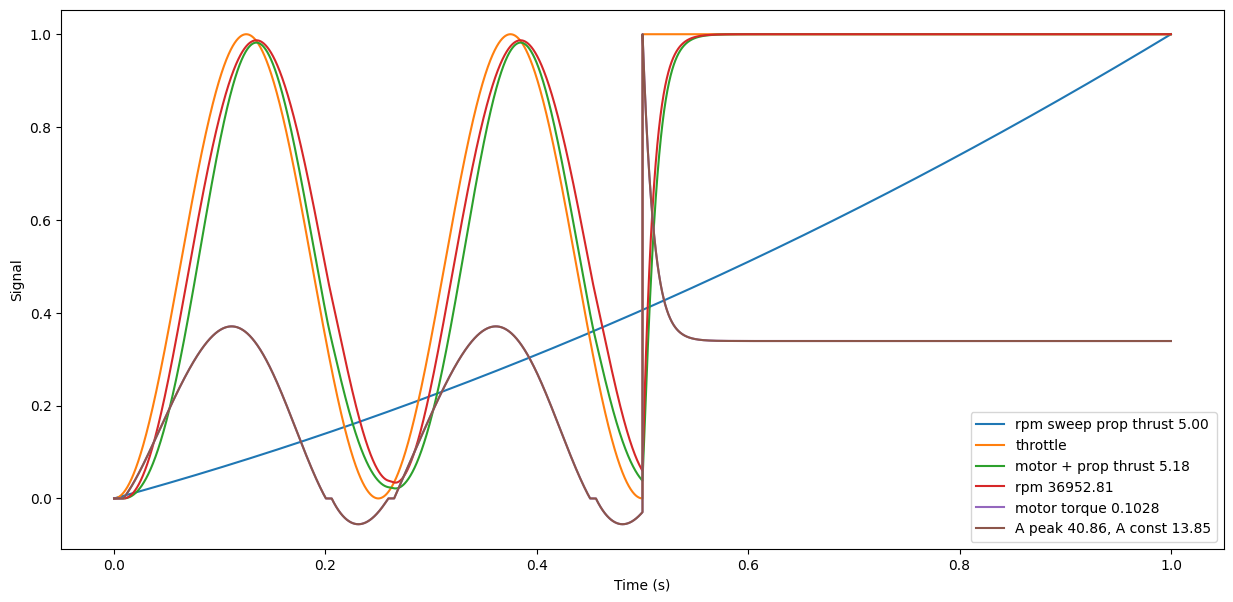

In [220]:
# calc & draw

def rpmToHz(rpm):
  return rpm / 60.0

def oscillation1f(amplitude, frequencyHz, t, phaseShift = 0):
  return amplitude * np.sin(2.0 * np.pi * frequencyHz * t + phaseShift)

def interpolate(x, y, i):
  return x * (1.0 - i) + y * i

output = 0.0

def lowpass(dt, cutoffFrequency, value):
  global output
  ePow = 1.0 - math.exp(-dt * 2.0 * math.pi * cutoffFrequency)
  output += (value - output) * ePow
  return output

def clamp(x, min, max):
  if (x < min):
    return min
  if (x > max):
    return max
  return x

def max(a, b):
  if(a > b):
    return a
  return b


def prop_thrust(rpm, vel):
  # max thrust vs velocity:
  propF = propThrustFactor_x * vel * vel + propThrustFactor_y * vel + propThrustFactor_z
  propF = max(0.0, propF)

  # thrust vs rpm (and max thrust)
  b = (propF - propA * maxRPM * maxRPM) / maxRPM
  result = b * rpm + propA * rpm * rpm

  return np.maximum(result, 0.0)

def prop_torque(rpm, vel):
  return prop_thrust(rpm, vel) * propTorqFactor

def motor_torque(volts, rpm):
  backEmfV = rpm / motorKV
  current = (volts - backEmfV) / (motorR * 3.0)

  if (current > 0):
    current = max(0.0, current - motorI0)
  elif (current < 0):
    current = min(0.0, current + motorI0)

  NmPerA = 8.3 / motorKV
  return current * NmPerA
  #old version:
  #return current * 60 / (motorKV * 2.0 * M_PI)

def motor_current(mTorque):
  return mTorque * motorKV / 8.3


def rpmCurve(throttleArray):
  current_rpm = 0

  rpmList = []
  thrustList = []
  motorTorqueList = []

  for throttleVal in np.nditer(throttleArray):
    pwm  = throttleVal * 1000.0 #+ 1000.0
    rpm = current_rpm

    volts = pwm / 1000.0 * vbat
    
    mtorque = motor_torque(volts, rpm)
    motorTorqueList.append(mtorque)

    ptorque = prop_torque(rpm, 0)
    nettorque = mtorque * 0.833 - ptorque
    domega = nettorque / propInertia

    drpm = (domega * dt) * 60.0 / (2.0 * M_PI)

    maxdrpm = abs(volts * motorKV - rpm)
    rpm += clamp(drpm, -maxdrpm, maxdrpm)

    pthrust= prop_thrust(rpm, 0)

    current_rpm = rpm

    rpmList.append(rpm)
    thrustList.append(pthrust)
  
  return np.array(rpmList), np.array(thrustList), np.array(motorTorqueList)

def setArray(arr, startIndex, endIndex, value):
  l = len(arr)
  for i in range(0, l):
    if i >= startIndex and i < endIndex:
      arr[i] = value



# Fixing random state for reproducibility
np.random.seed(19680801)

frequency = 20e3
delta = 1e6 / frequency

dt = delta / 1e6

time = 1
maxRpmFull = maxRPM

t = np.arange(0.0, time, dt)

#throttle = np.linspace(0, 1, len(t))
throttle = oscillation1f(0.5, 4, t, -math.pi / 2) + 0.5
setArray(throttle, time/dt/2, time/dt, 1)


rpmFull = np.linspace(0, maxRpmFull, len(t))

s1x = oscillation1f(1.0, rpmToHz(rpmFull),t)

# add some noise into the mix
nse1 = 0.5 * np.random.random(size=len(t))
sig = s1x + nse1
x = np.vectorize(lowpass)(dt, 10, sig)


# 345A for 1Nm @3300kv

thrustZeroVel = prop_thrust(rpmFull, 0.0)
rpm, thrust, motorTorque = rpmCurve(throttle)

motorCurrent = motor_current(motorTorque)

constMotorCurrent = motorCurrent[-1]
maxMotorCurrent = np.max(motorCurrent)
maxMotorTorque = np.max(motorTorque)
maxThrustZeroVel = np.max(thrustZeroVel)
maxThrust = np.max(thrust)
maxRpm = np.max(rpm)

motorCurrent = motorCurrent / maxMotorCurrent
motorTorque = motorTorque / maxMotorTorque
thrustZeroVel = thrustZeroVel / maxThrustZeroVel
thrust = thrust / maxThrust
rpm = rpm / maxRpm



NFFT = 256  # the length of the windowing segments
Fs = 1/dt  # the sampling frequency

fig, (ax1) = plt.subplots(nrows=1, sharex=True, figsize=(15, 7))
#ax1.plot(t, sig)
#ax1.plot(t, x)
ax1.plot(t, thrustZeroVel, label = 'rpm sweep prop thrust %.2f' % maxThrustZeroVel)
ax1.plot(t, throttle, label = 'throttle')
ax1.plot(t, thrust, label = 'motor + prop thrust %.2f' % maxThrust)
ax1.plot(t, rpm, label = 'rpm %.2f' % maxRpm)
ax1.plot(t, motorTorque, label = 'motor torque %.4f' % maxMotorTorque)
ax1.plot(t, motorCurrent, label = 'A peak %.2f, A const %.2f' % (maxMotorCurrent, constMotorCurrent))
ax1.legend()
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Signal')


plt.show()